# Transfer Learning Tutorial

- Transfer Learning is where you use a model which was trained on one dataset and use it for another dataset, typically for Image Classification tasks.

- This technique is booming since the last 5-10 years.

- The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

- In this notebook, we will use **Transfer Learning** to train a **Cat-Dog Image Classifier**, using the **VGG16 pretrained model**.

## What are the problems with training your own Deep Learning Model from scratch?

- DL models are data hungry.
    - You need lots of data, and collection & annotation of such large amounts of data is costly, time consuming.

- DL models take lot of time for training.
    - Due to the amount of data, training time can vary from hours - to even days.

&rarr; Hence, DL practitioners often do not prefer to train their own model from scratch, and the solution to the above mentioned problems, is to use '**Pretrained Models**'.

## Using Pretrained Models

- Pretrained models are usually CNNs which are trained on very large dataset (lakhs of samples) for Computer Vision tasks.

- For example, consider **ImageNet dataset**, which has over 1.4 million images of real life objects & animals, segregated into **1000** classes.
    - Some pretrained models which used ImageNet dataset are: VGG16, ResNet, MobileNet, etc.

- One issue with using a pretrained model directly for your project is that, if your classification task has output classes which are not present in the training dataset for your pretrained model, it becomes useless.

- The solution to this problem is **Transfer Learning**.

## Transfer Learning

Transfer Learning is a research problem in Machine Learning which  focuses on storing knowledge gained while solving one problem and applying it to a *different but related problem*.

Transfer Learning is inspired from real life learning. *For example*, most people learn how to ride a bicycle before learning how to ride a bike. The idea is, you use some learning from riding a bicycle and apply it to learn how to ride a bike (a related task) in a faster way.

&rarr; Basically, use knowledge from one domain in another different by related domain.

Let us now understand Transfer Learning with the help of our usecase - Cat & Dog Classification task using VGG16. Before that, first lets see what VGG16 pretrained model is

### Understand VGG16 in brief

The following diagram represents the architecture of the VGG16 Pretrained Model:

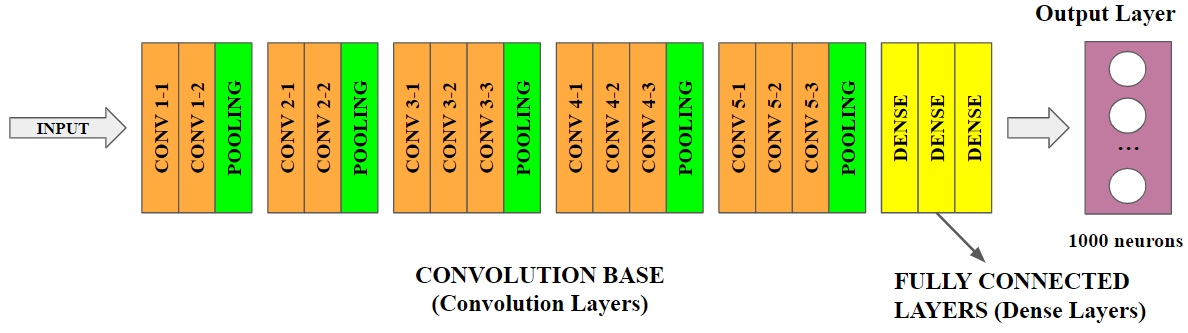

- VGG16 is a CNN which was trained on a subset of **ImageNet** dataset containing over 14 million images, and 1000 categories (classes).

- The output layer has 1000 units, with a 'Softmax' activation.

- The **Convolution Base** extracts the spatial information from an image.

- The **Fully Connected Layers** are used for classification purpose.

- The output labels for VGG16 can be found here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

## How Transfer Learning works

- Assume we want to do classification between Ferrari sports cars, and Audi passenger cars.
    - Developing a new CNN from scratch is not a good idea because we might not have enough training data.
    - Now, ImageNet dataset has different vehicles such as sports cars, minivans, etc. 
    - We can import a model which was *pretrained* on ImageNet dataset, and use the knowledge it had learnt for feature extraction in our example.

- Consider our usecase of Cat-Dog Classification using the VGG16 pretrained model.

- Assume Cats & Dogs are not present in the classes of the dataset VGG16 was trained on. How will you use the information VGG16 has, to build your own classifier on a related dataset?

- Remove the Fully Connected layers in VGG16, and put your own custom Fully Connected Layers on top the existing Conv Base along with your own output layer having sigmoid activation (Cats-Dogs -> Binary Classification)
- Now, freeze the Conv base.
- During training, since the Conv Base is frozen, only your own layers are trained, on your own dataset (of small size in comparision to ImageNet)
- So, here:
    - Through the frozen Conv Base, you are using the knowledge of ImageNet dataset's features.
    - Through your own Fully Connected Layers, you are adapting to your own dataset.

## Why Transfer Learning works?

- In a CNN, the Convolution Layers decode your images, and extract *features* from your images.
    - The initial set of layers extract *primitive features*, such as edges.
    - The inner set of layers extract *more complex features*, such as shapes.

- So, from ImageNet, which has 1000 classes belonging to real world objects & animals, the VGG16 model has learnt the features for most of the real world things.
    - This knowledge or information need not be learnt again. Hence, we freeze the Conv Base.
    - Then, you train only for the specific features of your custom classification task.

> DO NOT REINVENT THE WHEEL &rarr; Motto of Transfer Learning

## Ways to doing Transfer Learning

### 1. Feature Extraction

- Here, we do exactly what was described above about Transfer Learning:
    - Freeze the Conv Base
    - Remove the Dense layers
    - Add your own Dense layers & Output layer
    - Retrain on your data

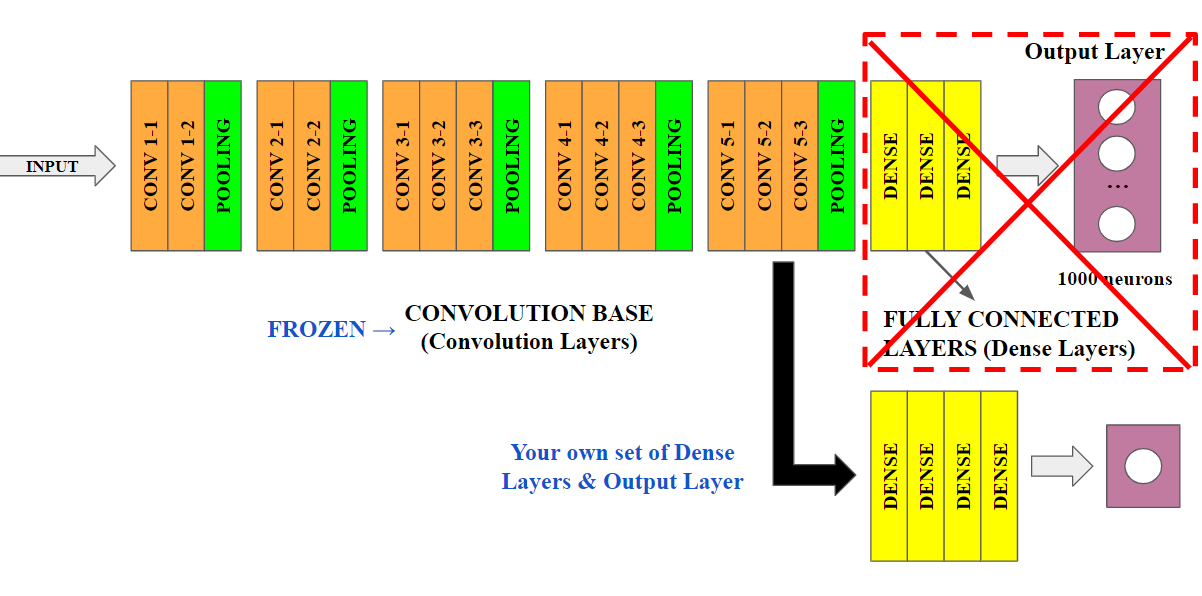

When is this done?
If your image classification task has output labels similar to the kind of data which the pretrained model was trained on.

### 2. Fine Tuning

- Here, we freeze most of the Conv Base, expect the last few layers. So:
    - Freeze most of the Conv Base expect a few last layers.
    - Have your own set of Dense Layers and output layer.
    - Retrain the last few layers of the Conv Base and your own set of Dense layers.

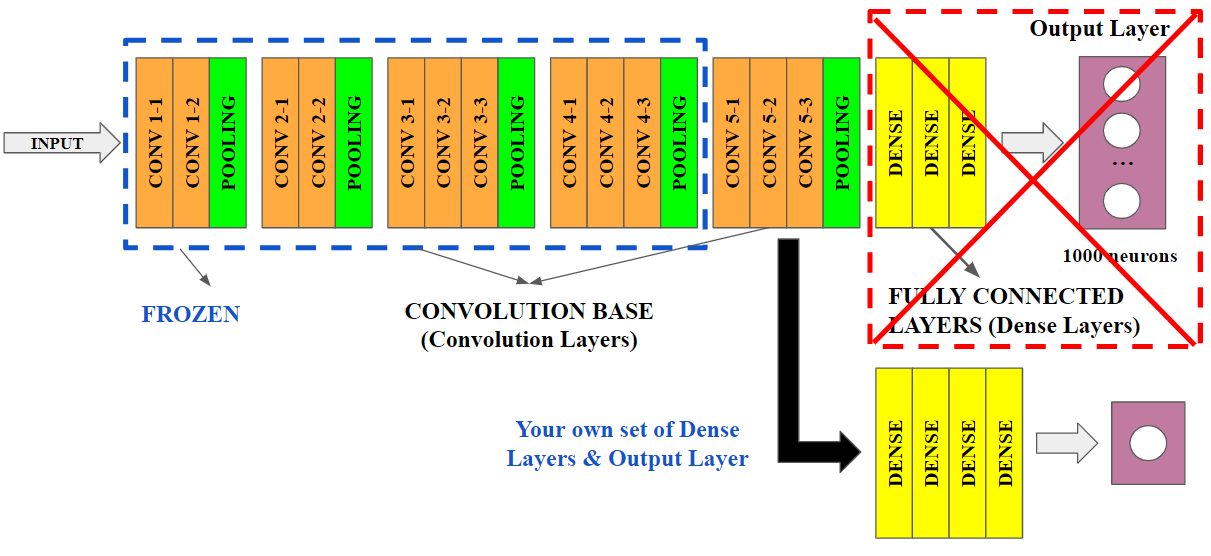

- In practice, for Fine Tuning, you use a very small learning rate.

- Here, you reuse the primitive features for learning the features of your dataset which has very different categories than the dataset the model was pretrained on.

- This takes some time to train, but gives good results.

> **NOTE**: For below implementation, the following are the references:
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://colab.research.google.com/drive/1VxoR4vMmZJAOCsDUnfezPuFQqHdKabcL?usp=sharing (Transfer Learning - Feature Extraction - Without Data Augmentation)
- https://colab.research.google.com/drive/1q_INiVDAzhSy1L_A87fBTf2wC3l3MiWy?usp=sharing (Transfer Learning - Feature Extraction - With Data Augmentation)
- https://colab.research.google.com/drive/1mEWfubs2tR0CkqyxqP49cK30n7V5_NCm?usp=sharing (Transfer Learning - Fine Tuning - Without Data Augmentation)

> **IMPORTANT:** After the conv base, dont forget to add a **Flatten** layer before the Dense layers.

## Building the models

Just like a normal ML task, we will apply the following tasks:

1. Loading & Exploring the Dataset

2. Data Preprocessing

3. Building the Model

4. Training the Model

5. Model Evaluation

In [1]:
# Import the generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

print(tf.__version__)
print(tf.test.gpu_device_name()) # GPU Usage

2.9.2
/device:GPU:0


## Loading the dataset & EDA

- Cats & Dogs Dataset: https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
(Navigate to this link in the browser to download the zip file)

- The dataset has **2000 training images** (1000 cat images, 1000 dog images) and **1000 validation images** (500 cat images, 500 dog images)

- We will download this dataset to the Google Colab's workspace.

- This dataset has the following structure:

```
cats_and_dogs_filtered
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat.1.jpg
│   │   ├── .....
│   ├── dogs
│   │   ├── dog.0.jpg
│   │   ├── dog.1.jpg
│   │   ├── .....
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat.2001.jpg
│   │   ├── .....
│   ├── dogs
│   │   ├── dog.2000.jpg
│   │   ├── dog.2001.jpg
│   │   ├── .....

```

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
print('Batch Size :', BATCH_SIZE)
print('Image Size :', IMG_SIZE)
print('Image Shape:', IMG_SHAPE)

Batch Size : 32
Image Size : (160, 160)
Image Shape: (160, 160, 3)


In [3]:
# Download the dataset
DATASET_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

dataset_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin = DATASET_URL, extract = True)

print(type(dataset_dir))
print(dataset_dir)

<class 'str'>
/root/.keras/datasets/cats_and_dogs.zip


In [4]:
# See the folder structure in the workspace
!ls ~/.keras
!ls ~/.keras/datasets
!ls ~/.keras/datasets/cats_and_dogs_filtered
!ls ~/.keras/datasets/cats_and_dogs_filtered/train
!ls ~/.keras/datasets/cats_and_dogs_filtered/validation

datasets  keras.json  models
cats_and_dogs_filtered	cats_and_dogs.zip
train  validation  vectorize.py
cats  dogs
cats  dogs


In [5]:
# Define the folder paths for the training & validation set
root_folder_path = os.path.dirname(dataset_dir)
print(root_folder_path)

dataset_path = os.path.join(root_folder_path, 'cats_and_dogs_filtered')
print(dataset_path)

train_dir_path = os.path.join(dataset_path, 'train')
val_dir_path = os.path.join(dataset_path, 'validation')

print(train_dir_path)
print(val_dir_path)

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [6]:
# Load the Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir_path,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [7]:
# Load the Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir_path,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 1000 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


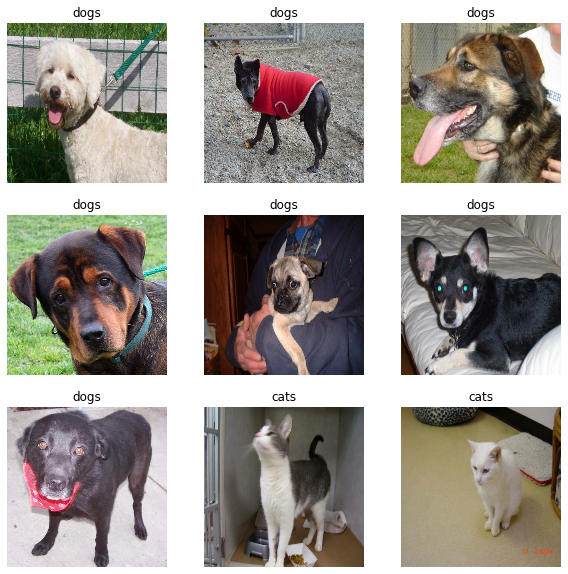

In [9]:
# Plot some images
_ = plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
train_batches = int(tf.data.experimental.cardinality(train_ds))
val_batches = int(tf.data.experimental.cardinality(val_ds))
print(train_batches, val_batches)

63 32


### Configure Dataset for performance

https://www.tensorflow.org/tutorials/images/transfer_learning#configure_the_dataset_for_performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Get the Pretrained Model (The Base Model)

- First, load the pretrained model using **`tf.keras.applications`** module: https://www.tensorflow.org/api_docs/python/tf/keras/applications

- **`VGG16()`** function is available in **`tf.keras.applications.vgg16`**

- By convention, such pretrained models are represented in a vertical manner, in a bottom to top manner.
    - The models contain some classification layers, which are on the top. These need not be included since we will have our own Dense layers. That is why we need to set the argument **`include_top`** to **`False`**

- This base model acts as our Convolution Base.

In [12]:
# Load the base model (the pretrained model)
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)

base_model.summary() # Look at the pretrained model's Architecture

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

Note that each pretrained model needs the input in a specific preprocessed format. To handle this generically, each pretrained model's module in `tf.keras` has its own **`preprocess_input`** function.

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input

In this notebook, lets use the *Keras Functional API*, rather than the *Sequential Model*: https://www.tensorflow.org/guide/keras/functional

In [13]:
# Define the preprocessing layer
preprocess_input = tf.keras.applications.vgg16.preprocess_input

Now, lets use this base model (Conv Base) and implement Transfer Learning in 2 ways:
- Feature Extraction
- Fine Tuning

For each of them, lets also compare the results with and without data augmentation.

## Transfer Learning - Feature Extraction

- Freeze the Conv Base and add your own custom classifier on top of that.

- Set the base model's **`trainable`** parameter to `False`. This will freeze all layers of the Conv Base.
    - Alternatively, you can iterate over the layer and do **`layer.trainable = False`**

In [14]:
# Freeze the Conv Base
base_model.trainable = False

In [15]:
# Define the Dense Layers
classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 256, activation = 'relu')
])

prediction_layer = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')

In [16]:
# Input Layer
inputs = tf.keras.layers.Input(shape = IMG_SHAPE)

# Preprocessing layer
x = preprocess_input(inputs)

# Conv Base
x = base_model(x)

# Flatten
flatten = tf.keras.layers.Flatten()
x = flatten(x)

# Dense Layers
x = classifier(x)

# Output layer
outputs = prediction_layer(x)

# Define the overall model
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 sequential (Sequential)     (None, 256)               3277056   
                                                             

In [17]:
# Compile the model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [18]:
# Train the model
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds
)

Epoch 1/10
63/63 [==============================] - 17s 188ms/step - loss: 3.4279 - accuracy: 0.9290 - val_loss: 0.6200 - val_accuracy: 0.9600
Epoch 2/10
63/63 [==============================] - 10s 149ms/step - loss: 0.1788 - accuracy: 0.9820 - val_loss: 0.6477 - val_accuracy: 0.9530
Epoch 3/10
63/63 [==============================] - 10s 148ms/step - loss: 0.0785 - accuracy: 0.9910 - val_loss: 0.7423 - val_accuracy: 0.9570
Epoch 4/10
63/63 [==============================] - 9s 144ms/step - loss: 0.2170 - accuracy: 0.9875 - val_loss: 0.8709 - val_accuracy: 0.9650
Epoch 5/10
63/63 [==============================] - 9s 142ms/step - loss: 0.1428 - accuracy: 0.9915 - val_loss: 1.1784 - val_accuracy: 0.9500
Epoch 6/10
63/63 [==============================] - 9s 139ms/step - loss: 0.1343 - accuracy: 0.9930 - val_loss: 0.9112 - val_accuracy: 0.9650
Epoch 7/10
63/63 [==============================] - 9s 139ms/step - loss: 0.0347 - accuracy: 0.9980 - val_loss: 0.9872 - val_accuracy: 0.9700
Epo

> I have no idea why the model is doing so well. As per the tutorials I followed, it shouldnt!😲

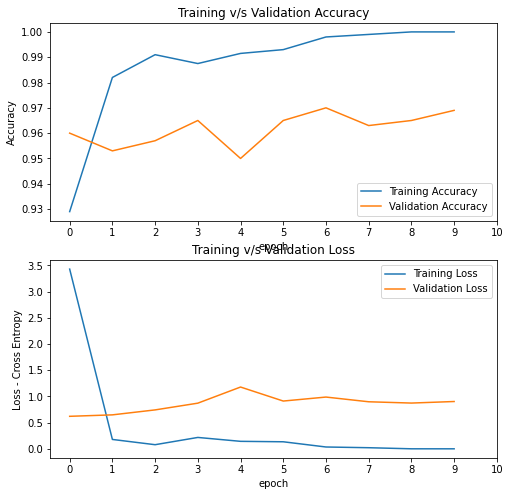

In [19]:
# Plot the accuracy & loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

_ = plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 10 + 1, 1))
plt.title('Training v/s Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss - Cross Entropy')
plt.xticks(np.arange(0, 10 + 1, 1))
plt.title('Training v/s Validation Loss')
plt.xlabel('epoch')

plt.show()

## Feature Extract along with Data Augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomZoom(height_factor = 0.15),
    tf.keras.layers.RandomRotation(factor = 0.15)
])

In [21]:
# Input Layer
inputs = tf.keras.layers.Input(shape = IMG_SHAPE)

# Data Augmentation
x = data_augmentation(inputs)

# Preprocessing layer
x = preprocess_input(x)

# Conv Base
x = base_model(x)

# Flatten
flatten = tf.keras.layers.Flatten()
x = flatten(x)

# Dense Layers
x = classifier(x)

# Output layer
outputs = prediction_layer(x)

# Define the overall model
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [22]:
# Compile the model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [23]:
# Train the model
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds
)

Epoch 1/10
63/63 [==============================] - 12s 174ms/step - loss: 0.7982 - accuracy: 0.9420 - val_loss: 0.4082 - val_accuracy: 0.9520
Epoch 2/10
63/63 [==============================] - 11s 165ms/step - loss: 0.3654 - accuracy: 0.9495 - val_loss: 0.7598 - val_accuracy: 0.9460
Epoch 3/10
63/63 [==============================] - 11s 165ms/step - loss: 0.4435 - accuracy: 0.9410 - val_loss: 0.2919 - val_accuracy: 0.9620
Epoch 4/10
63/63 [==============================] - 12s 182ms/step - loss: 0.2793 - accuracy: 0.9495 - val_loss: 0.3241 - val_accuracy: 0.9650
Epoch 5/10
63/63 [==============================] - 13s 207ms/step - loss: 0.1625 - accuracy: 0.9655 - val_loss: 0.2195 - val_accuracy: 0.9640
Epoch 6/10
63/63 [==============================] - 10s 163ms/step - loss: 0.1063 - accuracy: 0.9745 - val_loss: 0.1815 - val_accuracy: 0.9720
Epoch 7/10
63/63 [==============================] - 11s 164ms/step - loss: 0.0997 - accuracy: 0.9725 - val_loss: 0.3223 - val_accuracy: 0.9690

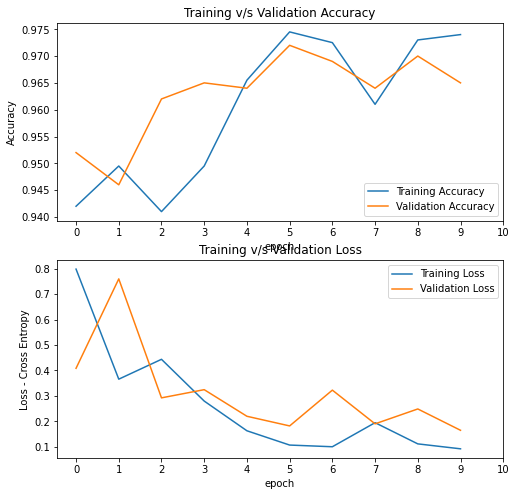

In [29]:
# Plot the accuracy & loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

_ = plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 10 + 1, 1))
plt.title('Training v/s Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss - Cross Entropy')
plt.xticks(np.arange(0, 10 + 1, 1))
plt.title('Training v/s Validation Loss')
plt.xlabel('epoch')

plt.show()

## Transfer Learning - Fine Tuning

Here is a good explanation from TF's Tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning)

- In the feature extraction experiment, you were only training a few layers on top of an VGG16 base model. 
    - The weights of the pre-trained network were not updated during training.
- One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. 
- The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
- **Note:** This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.
- Also, you should try to fine-tune a small number of top layers rather than the whole VGG16 model. 
- In most convolutional networks, the higher up a layer is, the more specialized it is. 
- The first few layers learn very simple and generic features that generalize to almost all types of images. 
- As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. 
- The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.
- **Note:** When fine tuning, you use a very low learning rate, so that you learn as much knowledge as possible, at the expense of time.

### Unfreeze the top layers

- First, unfreeze the entire **`base_model`**.

- Then, set **`layer.trainable`** to **`True`** for a few layers.

- In our case (VGG16), lets unfreeze the last convolution block (block 5)

In [24]:
# Unfreeze the entire base_model
base_model.trainable = True

# Freeze some bottom layers (In essence, you are unfreezing only certain top layers)
set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [25]:
# Input Layer
inputs = tf.keras.layers.Input(shape = IMG_SHAPE)

# Preprocessing layer
x = preprocess_input(inputs)

# Conv Base
x = base_model(x)

# Flatten
flatten = tf.keras.layers.Flatten()
x = flatten(x)

# Dense Layers
x = classifier(x)

# Output layer
outputs = prediction_layer(x)

# Define the overall model
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 sequential (Sequential)     (None, 256)               3277

In [26]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001 / 100),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [27]:
model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds
)

Epoch 1/10
63/63 [==============================] - 13s 160ms/step - loss: 0.0053 - accuracy: 0.9980 - val_loss: 0.1727 - val_accuracy: 0.9690
Epoch 2/10
63/63 [==============================] - 10s 160ms/step - loss: 1.5817e-04 - accuracy: 1.0000 - val_loss: 0.1980 - val_accuracy: 0.9700
Epoch 3/10
63/63 [==============================] - 11s 164ms/step - loss: 9.1373e-06 - accuracy: 1.0000 - val_loss: 0.1919 - val_accuracy: 0.9700
Epoch 4/10
63/63 [==============================] - 10s 163ms/step - loss: 9.5996e-07 - accuracy: 1.0000 - val_loss: 0.2165 - val_accuracy: 0.9720
Epoch 5/10
63/63 [==============================] - 10s 157ms/step - loss: 2.1891e-07 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9690
Epoch 6/10
63/63 [==============================] - 12s 190ms/step - loss: 2.2764e-08 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9690
Epoch 7/10
63/63 [==============================] - 10s 160ms/step - loss: 6.8242e-09 - accuracy: 1.0000 - val_loss: 0.241